<a href="https://colab.research.google.com/github/moqri/deep_cell/blob/master/naseq2image_cnnc_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
folder='dendritic'
expressions_url='https://mousescexpression.s3.amazonaws.com/dendritic_cell.h5'
labels_url='https://raw.githubusercontent.com/moqri/deep_cell/master/dendritic_gene_pairs_200.txt'

In [15]:
#get labels
!mkdir {folder}
!wget -O {folder}/labels.txt {labels_url}

--2020-03-14 20:21:02--  https://raw.githubusercontent.com/moqri/deep_cell/master/dendritic_gene_pairs_200.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 664772 (649K) [text/plain]
Saving to: ‘dendritic/labels.txt’

dendritic/labels.tx 100%[===================>] 649.19K  --.-KB/s    in 0.04s   

2020-03-14 20:21:03 (17.3 MB/s) - ‘dendritic/labels.txt’ saved [664772/664772]



In [16]:
# get expression data 
!wget -O {folder}/exprMatrix.h5 {expressions_url}
!wget -O {folder}/genes.txt https://raw.githubusercontent.com/xiaoyeye/CNNC/master/data/sc_gene_list.txt

mkdir: cannot create directory ‘dendritic’: File exists
--2020-03-14 20:21:05--  https://mousescexpression.s3.amazonaws.com/dendritic_cell.h5
Resolving mousescexpression.s3.amazonaws.com (mousescexpression.s3.amazonaws.com)... 52.216.143.148
Connecting to mousescexpression.s3.amazonaws.com (mousescexpression.s3.amazonaws.com)|52.216.143.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 675899084 (645M) [application/x-www-form-urlencoded]
Saving to: ‘dendritic/exprMatrix.h5’

dendritic/exprMatri 100%[===================>] 644.59M  47.4MB/s    in 14s     

2020-03-14 20:21:19 (45.7 MB/s) - ‘dendritic/exprMatrix.h5’ saved [675899084/675899084]

--2020-03-14 20:21:20--  https://raw.githubusercontent.com/xiaoyeye/CNNC/master/data/sc_gene_list.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.


In [0]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

def plot_image(expression_df_top,gene_a,gene_b):
  d=expression_df_top[[gene_a,gene_b]]
  d=d[d[gene_a]*d[gene_b]>1]
  x=np.log2(d+1)[gene_a].values
  y=np.log2(d+1)[gene_b].values

  fig, axs = plt.subplots(1, 3,figsize=(15,15))
  # Generate some test data

  sigmas = [ 8, 16, 32]

  for ax, s in zip(axs.flatten(), sigmas):
      ax.set(xlabel=gene_a+' expression', ylabel=gene_b+' expression')
      img, extent = myplot(x, y, s)
      ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
      ax.set_title("Smoothing with  $\sigma$ = %d" % s)

  return plt

In [18]:
genes= pd.read_table(folder+"/genes.txt",index_col=1,header=None,names=['gene', 'id'],delimiter=' ')
genes.head()

,gene
id,
16334,ins2
19241,tmsb4x
16333,ins1
67945,rpl41
11461,actb


In [19]:
expression_df = pd.read_hdf(folder+"/exprMatrix.h5",index_col=0)
expression_df.index.rename('cell_id',inplace=1)
expression_df.shape

(4126, 20463)

In [20]:
gene_names=[genes['gene'].ix[id] for id in expression_df.columns.values]
expression_df.columns=gene_names

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [21]:
expression_df.head()

,zglp1,vmn2r65,gm10024,oog3,ldlrap1,mdn1,ifi208,wfdc17,mfap1b,tmsb15b2,bc100530,gm15114,vmn1r223,umad1,dnajc3,fam129c,rsph3b,rnaset2a,fam174b,spink13,apela,gm10767,prcd,7420461p10rik,cep85l,gm10406,bc117090,olfr55,olfr239,btnl1,isg15,gm16387,defa30,vmn2r121,loc100038947,mup9,gm1979,gm1993,mup10,mup11,...,stard7,cercam,anapc2,ssx2ip,tm9sf4,hrh3,commd7,garnl3,zscan29,dnajc24,arfgef2,cul4a,sall4,abtb2,golga2,duox1,magi3,dnttip2,wdr47,usp53,olfml3,fgg,dpyd,adgrl2,4933434e20rik,eps8l3,clca4a,tchh,sec24b,ankrd50,clca4b,cept1,taf13,kcnc4,tmem56,arfip1,prmt6,ifi44,tiparp,kdm1a
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSE48968_GSM1189043_SRR935907,0.000000,0.0,0.0,0.0,0.000000,0.021149,0.099963,5550.873212,0.000000,0.0,0.0,0.000000,0.0,9.265009,15.460175,0.0,1.666426,67.126252,0.0,0.0,0.0,0.0,0.0,0.000000,0.292417,0.0,0.0,0.0,0.0,0.0,22.549960,0.850411,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,3.002395,0.199248,9.854028,0.000000,9.381185,0.0,0.000000,0.0,1.478695,4.768447,0.164827,0.389458,0.0,0.000000,0.591914,0.228469,0.199586,10.624149,2.689515,0.00000,0.0,0.266115,0.000000,0.158590,24.345290,0.0,0.382131,0.000000,10.188531,2.338631,0.063689,80.015987,23.724416,0.0,0.0,48.025297,0.0,0.000000,78.227920,0.067654
GSE48968_GSM1189045_SRR935909,0.000000,0.0,0.0,0.0,0.000000,0.028580,0.180114,8742.533195,4.106672,0.0,0.0,0.000000,0.0,0.000000,8.441251,0.0,41.217021,12.135940,0.0,0.0,0.0,0.0,0.0,0.000000,4.346736,0.0,0.0,0.0,0.0,0.0,5.242644,0.000000,0.0,0.0,1.218881,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.497147,0.0,0.000000,0.0,0.000000,0.000000,2.019498,1.684142,0.0,1.659542,0.639906,0.000000,0.000000,0.000000,3.922925,0.00000,0.0,0.000000,0.103823,12.430027,21.370283,0.0,0.573770,0.000000,37.352788,1.915338,0.000000,0.000000,0.000000,0.0,0.0,7.003484,0.0,0.125666,27.948567,0.000000
GSE48968_GSM1189047_SRR935911,0.000000,0.0,0.0,0.0,0.000000,0.184533,0.000000,10373.409195,0.701884,0.0,0.0,0.000000,0.0,14.628159,3.474553,0.0,2.379279,17.132591,0.0,0.0,0.0,0.0,0.0,0.000000,1.275712,0.0,0.0,0.0,0.0,0.0,0.634693,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,9.561700,0.982619,0.000000,0.000000,0.0,8.822728,0.0,0.000000,3.467171,0.805371,8.427373,0.0,22.602372,0.929631,0.000000,0.139316,1.353266,0.000000,0.76918,0.0,0.000000,0.000000,0.000000,1.089331,0.0,0.000000,0.448174,5.679583,0.000000,0.000000,0.000000,0.000000,0.0,0.0,51.248802,0.0,0.000000,6.552583,0.000000
GSE48968_GSM1189048_SRR935912,0.000000,0.0,0.0,0.0,1.102037,0.334246,0.000000,10735.189490,20.033072,0.0,0.0,2.343637,0.0,10.142056,30.962625,0.0,2.176571,20.338375,0.0,0.0,0.0,0.0,0.0,1.181858,1.470451,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.023779,0.0,0.0,0.0,0.0,0.0,...,3.632568,1.145071,1.820278,0.000000,2.378535,0.0,34.338673,0.0,0.000000,0.000000,0.757805,9.624295,0.0,4.962411,0.000000,0.000000,0.917615,2.228348,5.152194,0.00000,0.0,0.000000,0.331152,0.455707,23.318638,0.0,1.098050,0.000000,5.150518,16.494622,0.000000,17.091772,0.000000,0.0,0.0,3.971227,0.0,0.000000,14.643270,1.166414
GSE48968_GSM1189049_SRR935913,5.884803,0.0,0.0,0.0,0.000000,0.000000,0.156472,5089.802416,114.583994,0.0,0.0,0.000000,0.0,4.143567,1.833315,0.0,2.608450,20.371195,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,26.188372,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.155941,0.330524,1.804894,5.182706,0.0,0.000000,0.0,0.000000,0.000000,2.580030,0.121924,0.0,0.180214,1.019173,0.000000,0.000000,35.566227,0.000000,0.00000,0.0,0.000000,0.000000,0.124120,0.000000,0.0,0.996915,0.000000,19.122918,2.662292,0.000000,0.000000,0.000000,0.0,0.0,29.745039,0.0,0.218342,4.058339,0.000000


In [0]:
labels= pd.read_table(folder+"/labels.txt",index_col=False,header=None,names=['gene1', 'gene2','value'],delimiter='\t')
label_genes=set(list(labels.gene2)+list(labels.gene2))

In [23]:
common_genes=list(set(label_genes) & set(gene_names))
expression_df=expression_df[common_genes]
expression_df.shape

(4126, 15661)

In [24]:
expression_df=expression_df.loc[:, (expression_df != expression_df.iloc[0]).any()]  # remove constant columns
expression_df.shape

(4126, 15650)

In [25]:
expression_df=expression_df[(expression_df.T != 0).any()] # remove rows of zeros
expression_df.shape

(4123, 15650)

In [26]:
# drop low count genes
gene_count=expression_df.astype(bool).sum(axis=0)
cells=expression_df.count()
expression_df=expression_df[gene_count[gene_count>cells/10].index]
expression_df.shape

(4123, 10568)

In [27]:
expression_df.head()

,snupn,tti2,rab6a,cdc20b,sap30bp,ccsap,otud7b,nmd3,ptprt,2310022b05rik,tnfaip8,tgfbr1,vmn2r38,pgap1,lyl1,ptk2b,trip4,mccc2,xylt1,pja2,fosl2,rbm43,pdcd1lg2,myo15,gcc1,dcps,mkl2,ptpn9,cdk6,yae1d1,myt1l,tank,cdk13,rock2,olfr467,cox5b,adgre5,rad54l2,uap1l1,atad2b,...,srek1,ctdsp2,cxcl2,dhx37,cntn5,klrb1c,olr1,bco2,tnfsf15,pard6a,wbp4,ntng2,irs3,samd4,krcc1,casp1,tvp23b,prrg1,dram2,otogl,clip1,cbl,sh2d4a,cpeb4,cox7a1,rpl7,rbm41,satl1,lactb,cdh22,ddx55,bivm,gemin6,zdhhc15,9530053a07rik,adgra3,ifi214,gk,hectd1,eya3
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSE48968_GSM1189043_SRR935907,17.455312,56.449634,39.529707,0.0,0.0,1.629955,0.490544,0.000000,0.163488,0.0,18.070867,9.818695,0.0,0.000000,0.000000,52.106410,10.290613,0.420382,0.000000,8.822566,50.630382,0.0,0.951541,0.016897,0.0,0.000000,11.606121,3.383378,22.411048,18.201167,0.0,47.180276,0.856429,3.832406,0.0,437.351628,1.718614,10.402261,31.256410,3.680882,...,0.000000,3.280158,14118.727163,0.00000,6.989790,1.303964,720.653715,0.0,88.561575,16.497982,11.306452,24.939185,0.0,0.000000,62.183852,11.882374,0.00000,0.0,12.589717,0.0,0.312912,10.461371,0.0,25.032524,27.988856,383.699956,2.561002,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,107.871947,0.000000,0.0,52.090944,3.411797,24.295411
GSE48968_GSM1189045_SRR935909,0.000000,0.000000,106.836879,0.0,0.0,0.419550,0.126266,16.632351,0.000000,0.0,27.226955,5.433761,0.0,0.000000,0.000000,3.013210,3.747774,0.000000,5.341979,3.299272,1.136264,0.0,0.000000,0.000000,0.0,7.843224,0.000000,0.000000,0.814117,0.489475,0.0,6.420648,6.067242,4.488396,0.0,384.971051,1.032199,0.072366,0.000000,0.473729,...,0.000000,0.000000,4578.424215,0.09258,5.328314,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.029805,11.365616,0.00000,0.0,0.397967,0.0,0.281902,20.361885,0.0,3.928376,52.420961,138.938199,0.000000,0.0,0.0000,0.0,0.0,0.0,9.852284,0.000000,83.163797,0.040519,0.0,0.000000,7.490838,18.047772
GSE48968_GSM1189047_SRR935911,0.000000,0.000000,37.716547,0.0,0.0,2.438027,13.696430,1.026023,0.000000,0.0,72.312300,0.000000,0.0,0.336096,0.000000,9.318138,0.000000,0.000000,0.000000,0.000000,0.628846,0.0,2.490741,0.000000,0.0,0.000000,6.499909,0.000000,29.962195,39.347040,0.0,48.006421,0.883124,2.452181,0.0,263.420561,1.428133,0.000000,0.000000,0.000000,...,0.000000,0.000000,9027.727050,0.00000,0.844448,0.000000,79.924121,0.0,89.233581,0.000000,15.071832,0.000000,0.0,0.000000,7.181096,0.000000,0.00000,0.0,27.751289,0.0,0.000000,17.128791,0.0,10.004856,19.279792,163.302465,0.940862,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,71.281751,0.000000,0.0,0.000000,6.663501,1.735544
GSE48968_GSM1189048_SRR935912,0.000000,4.094555,13.074897,0.0,0.0,0.000000,0.402735,25.004539,0.469779,0.0,14.324533,0.000000,0.0,0.000000,0.606517,15.175052,20.761887,0.603982,0.000000,10.762448,8.801634,0.0,0.000000,0.048554,0.0,0.000000,7.290478,9.436154,17.657487,0.000000,0.0,54.884128,4.586298,8.320461,0.0,234.571181,3.997767,1.500309,12.687612,1.162305,...,0.000000,7.540398,21767.825155,0.00000,3.244513,0.000000,79.680213,0.0,138.807643,2.443648,14.439538,2.398744,0.0,1.121585,7.883144,26.134811,0.00000,0.0,19.674889,0.0,4.110392,2.783392,0.0,20.883099,131.220811,183.655109,0.000000,0.0,0.9197,0.0,0.0,0.0,0.000000,0.000000,53.090751,0.129237,0.0,0.925873,1.623139,0.000000
GSE48968_GSM1189049_SRR935913,0.000000,0.000000,2.225745,0.0,0.0,0.728961,0.438769,0.000000,0.000000,0.0,5.364636,0.658679,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130282,0.000000,0.0,72.238056,0.000000,0.0,0.000000,0.000000,0.000000,1.414513,0.000000,0.0,0.669345,3.838893,0.866501,0.0,339.793985,2.433936,3.834903,9.821485,1.013041,...,0.373623,1.711473,2566.551893,0.00000,4.713086,0.000000,6.340025,0.0,0.000000,0.000000,12.781852,13.230187,0.0,0.000000,0.000000,0.000000,1.80391,0.0,17.632256,0.0,0.000000,0.101081,0.0,37.666547,51.881276,220.232911,0.000000,0.0,0.0000,0.0,0.0,0.0,3.313193,0.549446,43.006335,0.000000,0.0,4.034859,

In [28]:
# get expression as percentage
expression_df=(100*expression_df.transpose() / expression_df.sum(1)).round(2).transpose()
expression_df

,snupn,tti2,rab6a,cdc20b,sap30bp,ccsap,otud7b,nmd3,ptprt,2310022b05rik,tnfaip8,tgfbr1,vmn2r38,pgap1,lyl1,ptk2b,trip4,mccc2,xylt1,pja2,fosl2,rbm43,pdcd1lg2,myo15,gcc1,dcps,mkl2,ptpn9,cdk6,yae1d1,myt1l,tank,cdk13,rock2,olfr467,cox5b,adgre5,rad54l2,uap1l1,atad2b,...,srek1,ctdsp2,cxcl2,dhx37,cntn5,klrb1c,olr1,bco2,tnfsf15,pard6a,wbp4,ntng2,irs3,samd4,krcc1,casp1,tvp23b,prrg1,dram2,otogl,clip1,cbl,sh2d4a,cpeb4,cox7a1,rpl7,rbm41,satl1,lactb,cdh22,ddx55,bivm,gemin6,zdhhc15,9530053a07rik,adgra3,ifi214,gk,hectd1,eya3
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSE48968_GSM1189043_SRR935907,0.0,0.01,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.0,0.07,0.0,0.0,0.0,0.0,...,0.00,0.00,2.12,0.0,0.00,0.0,0.11,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.00
GSE48968_GSM1189045_SRR935909,0.0,0.00,0.03,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.10,0.0,0.0,0.0,0.0,...,0.00,0.00,1.22,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.01,0.04,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00
GSE48968_GSM1189047_SRR935911,0.0,0.00,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.02,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.01,0.0,0.02,0.00,0.00,0.0,0.08,0.0,0.0,0.0,0.0,...,0.00,0.00,2.83,0.0,0.00,0.0,0.03,0.0,0.03,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.00,0.01,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00
GSE48968_GSM1189048_SRR935912,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0.01,0.00,0.0,0.00,0.0,0.01,0.01,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.00,0.0,0.02,0.00,0.00,0.0,0.09,0.0,0.0,0.0,0.0,...,0.00,0.00,8.04,0.0,0.00,0.0,0.03,0.0,0.05,0.0,0.01,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.01,0.05,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00
GSE48968_GSM1189049_SRR935913,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.11,0.0,0.0,0.0,0.0,...,0.00,0.00,0.86,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.01,0.02,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE78779_GSM2076658_SRR3196081,0.0,0.00,0.01,0.0,0.01,0.02,0.0,0.00,0.00,0.0,0.02,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.03,0.0,0.0,0.0,0.0,...,0.00,0.00,0.04,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.03,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.0,0.00
GSE78779_GSM2076659_SRR3196082,0.0,0.00,0.00,0.0,0.00,0.03,0.0,0.00,0.00,0.0,0.11,0.00,0.0,0.00,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.02,0.00,0.00,0.0,0.01,0.00,0.00,0.0,0.08,0.0,0.0,0.0,0.0,...,0.01,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00,0.01,0.09,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.00,0.0,0.01
GSE78779_GSM2076660_SRR3196083,0.0,0.00,0.01,0.0,0.00,0.03,0.0,0.00,0.00,0.0,0.02,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.08,0.0,0.0,0.0,0.0,...,0.01,0.00,0.05,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0

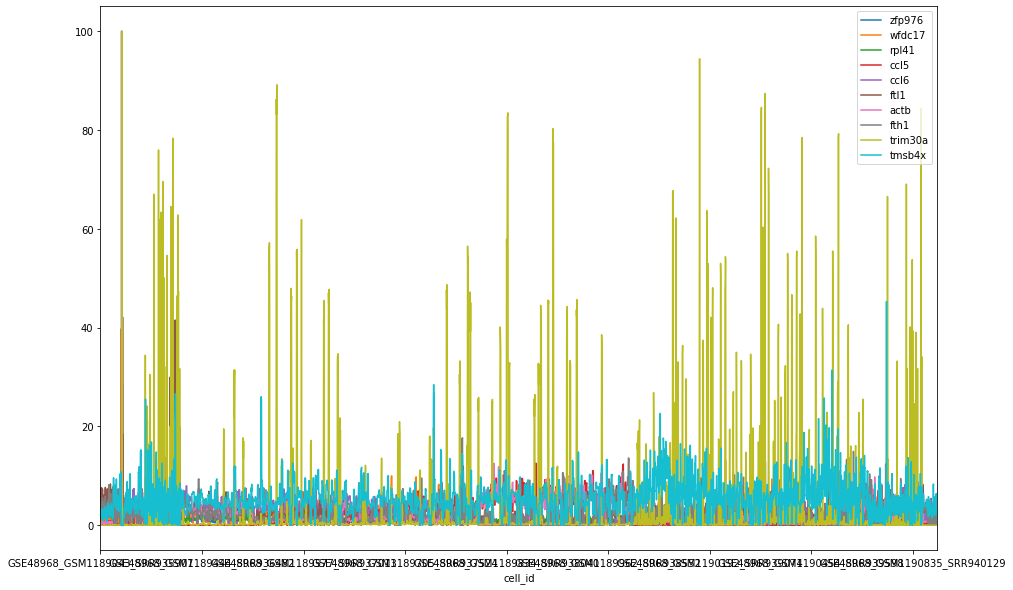

In [30]:
gene_sum=expression_df.sum()
top_10=gene_sum.sort_values().tail(10)
expression_df_top=expression_df[top_10.index]
expression_df_top.plot(figsize=(15,10))

In [31]:
corr=expression_df_top.corr()
corr

,zfp976,wfdc17,rpl41,ccl5,ccl6,ftl1,actb,fth1,trim30a,tmsb4x
zfp976,1.000000,0.141174,0.021197,-0.263794,0.229137,0.897131,-0.220258,0.437854,-0.147995,-0.193840
wfdc17,0.141174,1.000000,0.098942,-0.255815,0.389980,0.226584,-0.276333,0.239448,-0.095715,-0.084815
rpl41,0.021197,0.098942,1.000000,-0.099975,0.071905,0.108074,-0.005204,0.038456,-0.169843,0.376137
ccl5,-0.263794,-0.255815,-0.099975,1.000000,-0.283351,-0.217455,0.533268,-0.051349,-0.180698,0.077254
ccl6,0.229137,0.389980,0.071905,-0.283351,1.000000,0.311247,-0.201406,0.185696,-0.134926,-0.137003
ftl1,0.897131,0.226584,0.108074,-0.217455,0.311247,1.000000,-0.149802,0.490743,-0.167132,-0.113562
actb,-0.220258,-0.276333,-0.005204,0.533268,-0.201406,-0.149802,1.000000,-0.174970,-0.187228,0.260021
fth1,0.437854,0.239448,0.038456,-0.051349,0.185696,0.490743,-0.174970,1.000000,-0.120705,-0.166993
trim30a,-0.147995,-0.095715,-0.169843,-0.180698,-0.134926,-0.167132,-0.187228,-0.120705,1.000000,-0.232587
tmsb4x,-0.193840,-0.084815,0.376137,0.077254,-0.137003,-0.113562,0.260021,-0.166993,-0.232587,1.000000


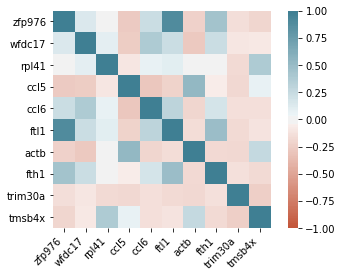

In [32]:
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

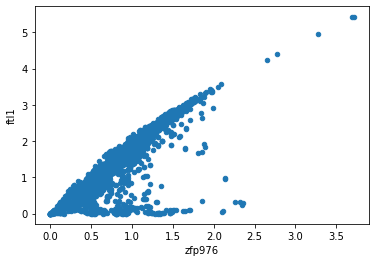

In [33]:
gene_a='zfp976'
gene_b='ftl1'
np.log2(expression_df_top+1).plot.scatter(gene_a,gene_b)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

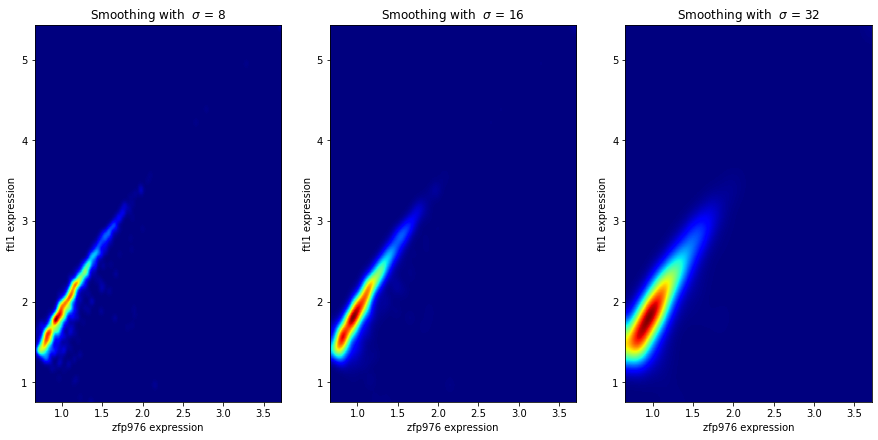

In [36]:
plot_image(expression_df_top,gene_a,gene_b)

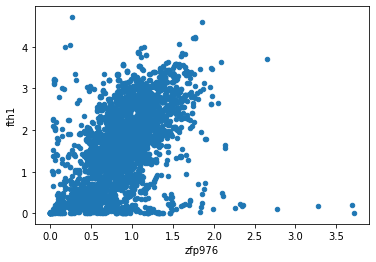

In [43]:
gene_a='zfp976'
gene_b='fth1'
np.log2(expression_df_top+1).plot.scatter(gene_a,gene_b)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

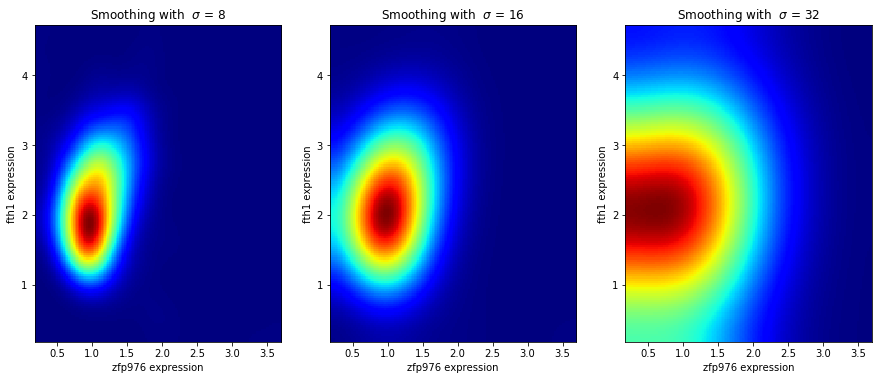

In [44]:
plot_image(expression_df_top,gene_a,gene_b)

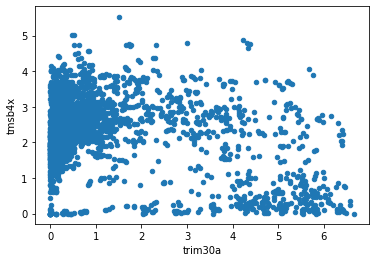

In [39]:
gene_a='trim30a'
gene_b='tmsb4x'
np.log2(expression_df_top+1).plot.scatter(gene_a,gene_b)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

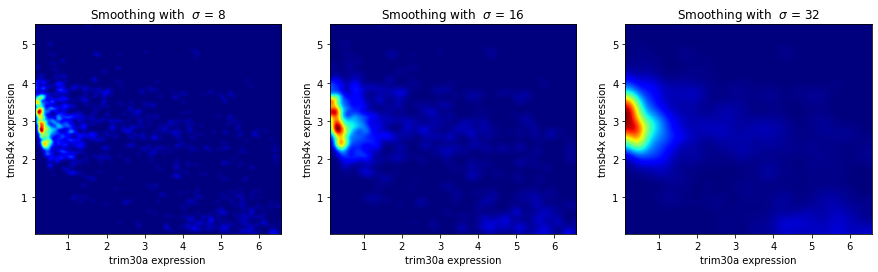

In [40]:
plot_image(expression_df_top,gene_a,gene_b)

In [88]:
# working on producing better data for the CNN
# most expressed genes
gene_sum=expression_df.sum()
high_expressed=gene_sum.sort_values().tail(5000)
high_expressed

cir1           5.28
gadd45g        5.28
cdh8           5.28
txndc15        5.29
naa25          5.29
             ...   
ftl1        8803.43
actb        9466.17
fth1       10690.29
trim30a    15083.14
tmsb4x     22155.78
Length: 5000, dtype: float64

In [0]:
labels['gene1_top']=labels.gene1.apply(lambda x:1 if x in high_expressed.index else 0)
labels['gene2_top']=labels.gene2.apply(lambda x:1 if x in high_expressed.index else 0)

In [93]:
top_labels=labels[labels['gene1_top']*labels['gene2_top']>0]
top_labels.value.value_counts()


2    3389
1    3389
0    1477
Name: value, dtype: int64

In [0]:
top_labels[['gene1','gene2','value']].to_csv('top_lables.txt',index=False,sep='\t',header=False)